In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

#------------------------------------------------------
# 1. set seed
#------------------------------------------------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# variables
TRAIN_PATH = r"../input/silero-stress-predictor/train.csv"
TEST_PATH = r"../input/silero-stress-predictor/test.csv"

df = pd.read_csv(TRAIN_PATH)

# build character dictionary
vocab = set()
for word in df['word']:
    vocab.update(list(word))
vocab = sorted(list(vocab))
# index: 0 – for PAD
char2idx = {char: idx+1 for idx, char in enumerate(vocab)}
vocab_size = len(char2idx) + 1  # +1 for PAD
max_len = df['word'].apply(len).max()

#------------------------------------------------------------------
# 2. Create custom dataset
#------------------------------------------------------------------
class StressDataset(Dataset):
    def __init__(self, dataframe, char2idx, max_len):
        self.words = dataframe['word'].tolist()
        self.labels = dataframe['stress'].tolist()
        self.char2idx = char2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        label = self.labels[idx] - 1  # change into 0-index for CrossEntropyLoss
        indices = [self.char2idx.get(ch, 0) for ch in word]
        # padding to max_len
        if len(indices) < self.max_len:
            indices = indices + [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_df, val_df = train_test_split(df, test_size=0.32, random_state=42)
train_dataset = StressDataset(train_df, char2idx, max_len)
val_dataset = StressDataset(val_df, char2idx, max_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#------------------------------------------------------------------
# 3. Определим улучшенную модель CNN с Dropout и BatchNorm
#------------------------------------------------------------------

class CRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_len, lstm_hidden, dropout_p=0.4):
        super(CRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # CNN блок
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.pool = nn.MaxPool1d(kernel_size=2)  # уменьшает длину последовательности в 2 раза
        self.dropout = nn.Dropout(dropout_p)

        # После свёрточного блока последовательность имеет длину max_len//2
        # Преобразуем её для LSTM: (batch, max_len//2, 64)
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden, num_layers=1,
                            batch_first=True, bidirectional=True)
        # Финальный классификатор, на вход 2*lstm_hidden (конкатенация forward и backward)
        self.fc = nn.Linear(2 * lstm_hidden, num_classes)

    def forward(self, x):
        # x: (batch, max_len)
        x = self.embedding(x)               # -> (batch, max_len, embedding_dim)
        x = x.permute(0, 2, 1)              # -> (batch, embedding_dim, max_len)
        x = self.conv1(x)                   # -> (batch, 64, max_len)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.pool(x)                    # -> (batch, 64, max_len//2)

        x = x.permute(0, 2, 1)              # -> (batch, max_len//2, 64)
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (batch, max_len//2, 2*lstm_hidden)
        # Используем последние скрытые состояния обоих направлений
        # h_n имеет форму (num_layers * num_directions, batch, lstm_hidden)
        h_forward = h_n[-2, :, :]  # forward, размер: (batch, lstm_hidden)
        h_backward = h_n[-1, :, :] # backward, размер: (batch, lstm_hidden)
        h = torch.cat((h_forward, h_backward), dim=1)  # -> (batch, 2*lstm_hidden)

        h = self.dropout(h)
        logits = self.fc(h)               # -> (batch, num_classes)
        return logits

embedding_dim = 32
num_classes = 6
lstm_hidden = 64
model = CRNNModel(vocab_size, embedding_dim, num_classes, max_len, lstm_hidden)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#------------------------------------------------------------------
# 4. Scheduler: reducation lr if val fails
#------------------------------------------------------------------
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# train func
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

#val func
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total
#------------------------------------------------------------------
# 5. Основной цикл обучения с сохранением лучшей модели
#------------------------------------------------------------------
num_epochs = 20
best_val_acc = 0.0

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step(val_acc)

    # Сохраняем метрики в history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved best model!")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.8680 - Train Acc: 0.6175 - Val Loss: 0.7157 - Val Acc: 0.6980
Saved best model!
Epoch 2/20 - Train Loss: 0.6726 - Train Acc: 0.7242 - Val Loss: 0.6166 - Val Acc: 0.7513
Saved best model!
Epoch 3/20 - Train Loss: 0.5884 - Train Acc: 0.7644 - Val Loss: 0.5584 - Val Acc: 0.7755
Saved best model!
Epoch 4/20 - Train Loss: 0.5367 - Train Acc: 0.7871 - Val Loss: 0.5473 - Val Acc: 0.7816
Saved best model!
Epoch 5/20 - Train Loss: 0.4909 - Train Acc: 0.8071 - Val Loss: 0.5104 - Val Acc: 0.7966
Saved best model!
Epoch 6/20 - Train Loss: 0.4617 - Train Acc: 0.8189 - Val Loss: 0.4771 - Val Acc: 0.8104
Saved best model!
Epoch 7/20 - Train Loss: 0.4254 - Train Acc: 0.8320 - Val Loss: 0.4588 - Val Acc: 0.8200
Saved best model!
Epoch 8/20 - Train Loss: 0.3924 - Train Acc: 0.8464 - Val Loss: 0.4449 - Val Acc: 0.8257
Saved best model!
Epoch 9/20 - Train Loss: 0.3675 - Train Acc: 0.8561 - Val Loss: 0.4355 - Val Acc: 0.8298
Saved best model!
Epoch 10/20 - Train Loss: 0.3418 - Tr

# Графики потерь и точности на протяжении 20 эпох

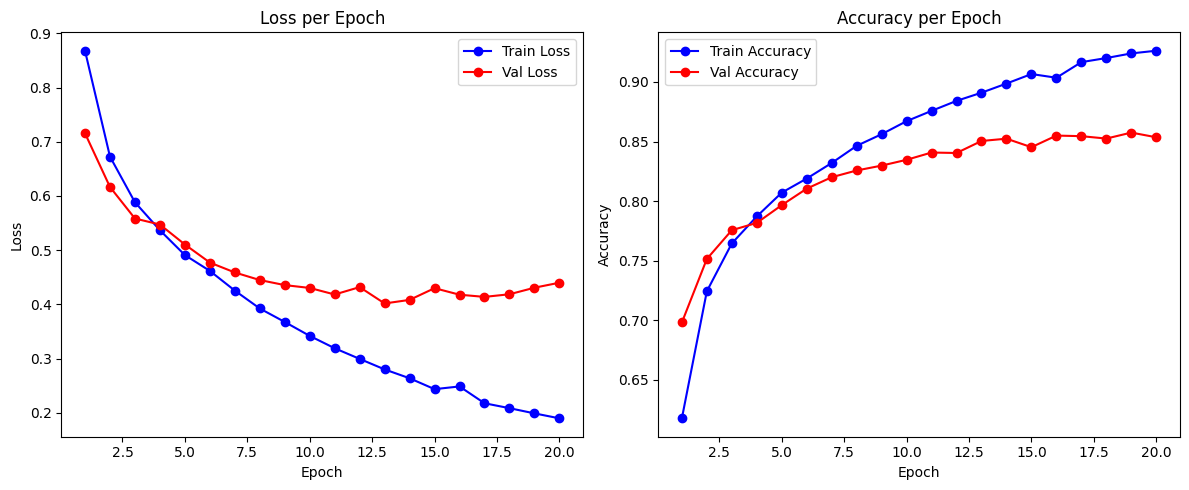

In [2]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точностей
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'bo-', label='Train Accuracy')
plt.plot(epochs, history['val_acc'], 'ro-', label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Предсказания модели

In [3]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
model.eval()

<ipython-input-3-66f6184886f3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt', map_location=device))


CRNNModel(
  (embedding): Embedding(34, 32, padding_idx=0)
  (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [4]:
def predict_word(word, model, char2idx, max_len, device='cpu'):
    # Преобразуем строку в последовательность индексов
    indices = [char2idx.get(ch, 0) for ch in word]
    # Паддинг или обрезка до max_len
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    
    x = torch.tensor([indices], dtype=torch.long, device=device)

    with torch.no_grad():
        output = model(x)
    # Выбираем класс с максимальной вероятностью
    # Добавляем +1, т.к. при обучении сделали изменение индексов от 0 до 5
    pred = torch.argmax(output, dim=1).item() + 1  
    return pred

test_df = pd.read_csv('../input/silero-stress-predictor/test.csv', index_col=0)

# Получаем предсказания для каждого слова
Y_test = [predict_word(word, model, char2idx, max_len, device) for word in test_df['word']]

eval_df = pd.DataFrame({'stress': Y_test}, index=test_df.index)
eval_df.to_csv('submission.csv')

# Объединение с тестовыми данными
result_df = pd.concat([test_df, eval_df], axis=1)
print(result_df.head())

             word  num_syllables        lemma  stress
id                                                   
0       эпилепсия              5    эпилепсия       3
1     относящейся              5   относиться       3
2   размышлениями              6  размышление       3
3          модемы              3        модем       2
4           солнц              1       солнце       1
